# DenoiSeg Example: Example Flywing data
This is an example notebook which illustrates how DenoiSeg should be trained. In this notebook we use a membrane labeled developing Fly Wing dataset from our collaborators. This notebook can be used as a reference to train DenoiSeg networks on your own data.

In [1]:
# Here we are just importing some libraries which are needed to run this notebook.

import warnings
warnings.filterwarnings('ignore')

import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage

from denoiseg.models import DenoiSeg, DenoiSegConfig
from denoiseg.utils.misc_utils import combine_train_test_data, shuffle_train_data, augment_data
from denoiseg.utils.seg_utils import *
from denoiseg.utils.compute_precision_threshold import measure_precision, compute_labels
from denoiseg.utils.denoiseg_data_preprocessing import generate_patches_from_list

from csbdeep.utils import plot_history
from tifffile import imread, imsave
from glob import glob

import urllib
import os
import zipfile
import cv2

2023-07-20 17:10:20.013615: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-20 17:10:20.744646: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def plot(i, img, lbl, mode):
    img_, lbl_ = img[i], lbl[i]
    plt.figure(figsize=(16,10))
    plt.subplot(121); plt.imshow(img_,cmap='gray');   plt.axis('off'); plt.title(f'Raw image {mode}')
    plt.subplot(122); plt.imshow(lbl_, cmap='gray');   plt.axis('off'); plt.title(f'Mask image {mode}')
    plt.show()
    print(np.min(img_),np.max(img_))
    print(np.min(lbl_),np.max(lbl_))

## Downloading and  Data Loading
We download a dataset consisting of noisy flywing images. The downloaded data creates a folder `MyData` and extracts within it three subfolders `train`, `val` and `test`. These folders have subfolders `raw` and `gt`. In `train/raw` folder, there are `1428` raw images and only the first `5` of raw images have ground truth annotations in folder `train/gt`. Similarly, in `val/raw` folder, there are `252` raw images and only the first `2` of raw images have ground truth annotations in folder `val/gt`. The `test` folder only has `raw` subfolder since these are the images we want denoised and segmented outputs for.

In [4]:
train_imgs_dir = './data/patches/g123/train/imgs/'
train_lbls_dir = './data/patches/g123/train/labels'

val_imgs_dir = './data/patches/g123/val/imgs/'
val_lbls_dir = './data/patches/g123/val/labels'

In [5]:
# Loading of the training images
train_images = imread(sorted(glob(os.path.join(train_imgs_dir ,'*.tif'))))
val_images = imread(sorted(glob(os.path.join(val_imgs_dir ,'*.tif'))))
# test_images = imread(sorted(glob("data/MyData/test/raw/*.tif")))

available_train_masks = imread(sorted(glob(os.path.join(train_lbls_dir ,'*.tif'))))
available_val_masks = imread(sorted(glob(os.path.join(val_lbls_dir ,'*.tif'))))

In [6]:
image = cv2.imread('./data/cvat_g123/Tile_001-002-000_0-000.png', 3)

### Create zero images for missing masks

Here we create zero images for those training and validation images for which segmentation masks are not present. Then we use these zero images along with the images for which segmentation annotations are available for training the DenoiSeg network.

In [45]:
blank_images_train = np.zeros((train_images.shape[0]-available_train_masks.shape[0], available_train_masks.shape[1], available_train_masks.shape[2], available_train_masks.shape[3]))
blank_images_val = np.zeros((val_images.shape[0]-available_val_masks.shape[0], available_val_masks.shape[1], available_val_masks.shape[2], available_val_masks.shape[3]))
blank_images_train = blank_images_train.astype("uint16")
blank_images_val = blank_images_val.astype("uint16")

train_masks = np.concatenate((available_train_masks,blank_images_train), axis = 0)
val_masks = np.concatenate((available_val_masks,blank_images_val), axis = 0)

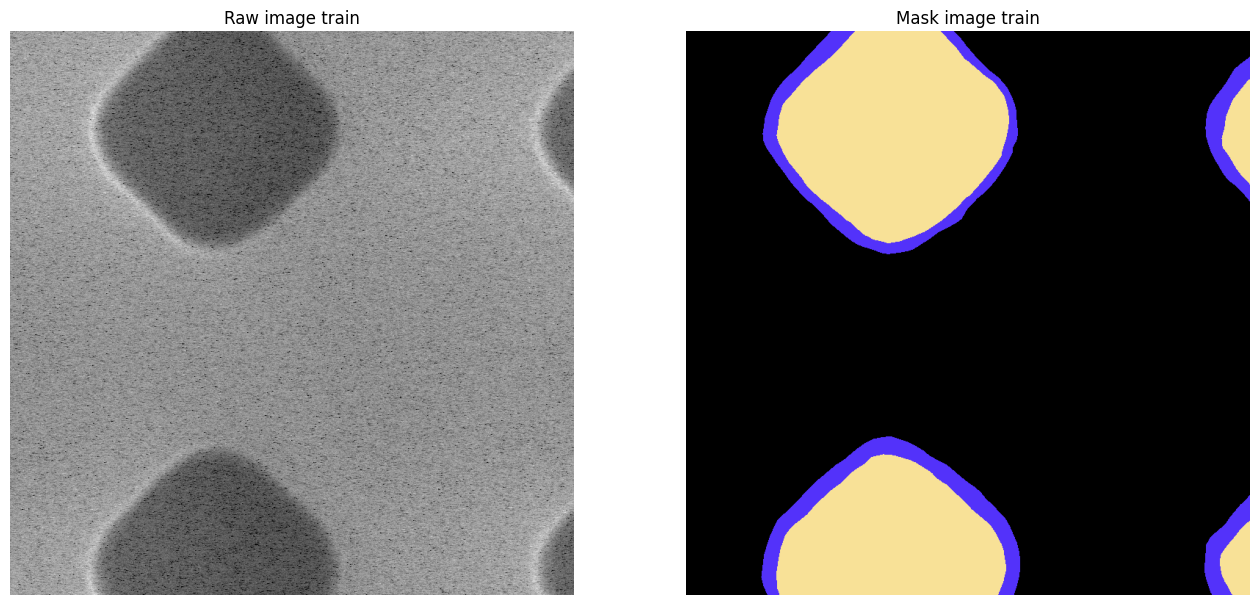

0 149
0 250


In [46]:
plot(100, train_images, train_masks, 'train')

## Data Preprocessing
We do some necessary data preprocessing in the cell below such as augmenting training data; extracting foreground, background and border classes from our training and validation masks.

In [47]:
# Here we add the channel dimension to our input images.
# Dimensionality for training has to be 'SYXC' (Sample, Y-Dimension, X-Dimension, Channel)
X_final = train_images[... ,np.newaxis]
print('processing y final')
Y_final = convert_to_oneHot(train_masks, n_classes=3)

print('processing x val')
X_val_final = val_images[... ,np.newaxis]
print('processing y val')
Y_val_final = convert_to_oneHot(val_masks, n_classes=3)

print("Shape of X:     {}".format(X_final.shape))
print("Shape of Y:     {}".format(Y_final.shape))
print("Shape of X_val: {}".format(X_val_final.shape))
print("Shape of Y_val: {}".format(Y_val_final.shape))

processing y final
processing x val
processing y val
Shape of X:     (720, 768, 768, 1)
Shape of Y:     (720, 768, 768, 3, 3)
Shape of X_val: (30, 768, 768, 1)
Shape of Y_val: (30, 768, 768, 3, 3)


Next we look at a single sample. In the first column we show the input image, in the second column the background segmentation, in the third column the foreground segmentation and in the last column the border segmentation.

With the parameter `sample` you can choose different training patches. You will notice that not all of them have a segmentation ground truth.

In [52]:
np.unique(Y_final)

: 

: 

Text(0.5, 1.0, '1-hot encoded border')

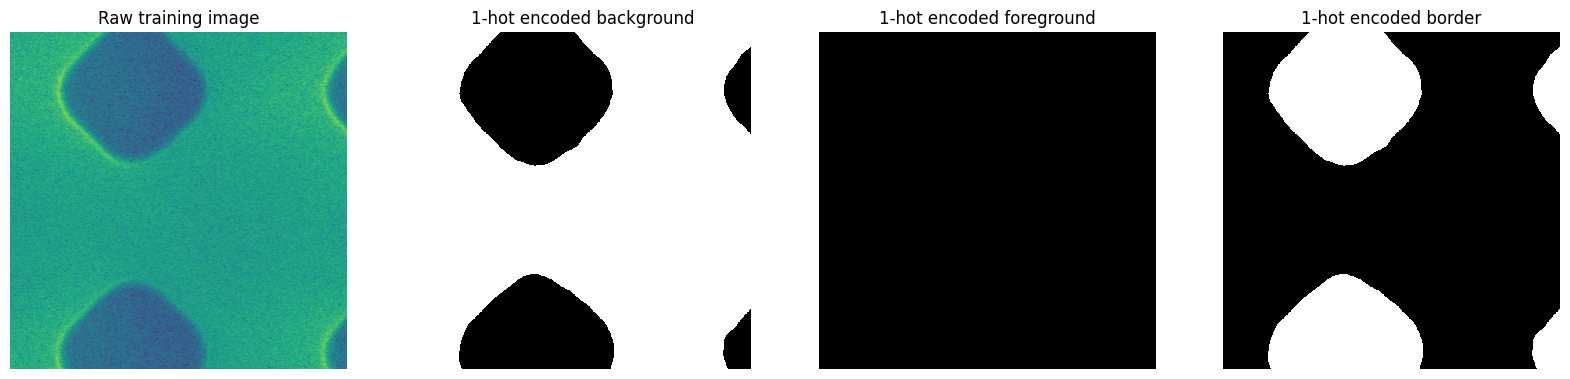

In [49]:
sample = 100
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(X_final[sample,...,0])
plt.axis('off')
plt.title('Raw training image')
plt.subplot(1,4,2)
plt.imshow(Y_final[sample,...,0], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded background')
plt.subplot(1,4,3)
plt.imshow(Y_final[sample,...,1], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded foreground')
plt.subplot(1,4,4)
plt.imshow(Y_final[sample,...,2], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded border')



### Configure network parameters

In [27]:
train_batch_size = 128
train_steps_per_epoch = min(400, max(int(X_final.shape[0]/train_batch_size), 10))

In [28]:
### In the next cell, you can choose how much relative importance (weight) to assign to denoising 
### and segmentation tasks by choosing appropriate value for denoiseg_alpha (between 0 and 1; with 0 being
### only segmentation and 1 being only denoising. Here we choose denoiseg_alpha = 0.5)

In [30]:
conf = DenoiSegConfig(X_final, unet_kern_size=3, n_channel_in=1, n_channel_out=4, relative_weights = [1.0,1.0,5.0],
                      train_steps_per_epoch=train_steps_per_epoch, train_epochs=120, 
                      batch_norm=True, train_batch_size=128, unet_n_first = 32, 
                      unet_n_depth=4, denoiseg_alpha=0.5, train_tensorboard=False)

vars(conf)

{'means': ['74.291644489618'],
 'stds': ['17.892137832781657'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 5,
 'train_loss': 'denoiseg',
 'unet_n_depth': 4,
 'relative_weights': [1.0, 1.0, 5.0],
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'probabilistic': False,
 'unet_residual': False,
 'unet_input_shape': (None, None, 1),
 'train_epochs': 120,
 'train_steps_per_epoch': 10,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': False,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'train_reduce_lr': {'monitor': 'val_loss', 'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 1.5,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'denoiseg_alpha': 0.5}

In [31]:
model_name = 'DenoiSeg_g123'
basedir = 'models'
model = DenoiSeg(conf, model_name, basedir)

In [32]:
history = model.train(X_final, Y_final, (X_val_final, Y_val_final))

61 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 30/30 [00:06<00:00,  4.42it/s]


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 4 dimension(s) and the array at index 1 has 5 dimension(s)

In [ ]:
history.history.keys()

In [ ]:
plot_history(history, ['loss', 'val_loss'])

## Computing Threshold Value
The network predicts 4 output channels:
1. The denoised input.
2. The foreground likelihoods.
3. The background likelihoods.
4. The border likelihoods.

We will threshold the foreground prediction image to obtain object segmentations. The optimal threshold is determined on the validation data. Additionally we can optimize the threshold for a given measure. In this case we choose the Average Precision (AP) measure.

In [ ]:
threshold, val_score = model.optimize_thresholds(val_images[:available_val_masks.shape[0]].astype(np.float32), val_masks, measure=measure_precision(), axes='YX')

print("The higest score of {} is achieved with threshold = {}.".format(np.round(val_score, 3), threshold))

## Test Data
Finally we load the test data and run the prediction.

In [ ]:
denoised_images = []
segmented_images = []

for i in range(test_images.shape[0]):
    predicted_channels = model.predict(test_images[i].astype(np.float32), axes='YX')
    denoised_images.append(predicted_channels[...,0])
    segmented_images.append(compute_labels(predicted_channels, threshold))

### Visualize the results

In [ ]:
sl = 6
fig = plt.figure()
plt.figure(figsize=(20,10))
plt.subplot(1, 4, 1)
plt.imshow(test_images[sl])
plt.title("Raw image")

plt.subplot(1, 4, 2)
plt.imshow(denoised_images[sl])
plt.title("Predicted denoised image")

plt.subplot(1, 4, 3)
plt.imshow(segmented_images[sl], cmap = "viridis")
plt.title("Predicted segmentation")

plt.show()

### Export your model for Fiji

In [ ]:
model.export_TF(name='DenoiSeg - YourOwnData Example', 
                description='This is the 2D DenoiSeg example trained on YourOwnData in python.', 
                authors=["You"],
                test_img=X_val[0,...,0], axes='YX',
                patch_shape=(128, 128))